# Modeling with TensorFlow and XGBoost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'acms80695-384817' # Project ID inserted based on the query results selected to explore
location = 'us-central1' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define a custom color palette with a single black color
black_palette = sns.color_palette(['black'])

# Set the color palette to the custom palette
sns.set_palette(black_palette)

# Set the Style to Darkgrid
sns.set_style("darkgrid")

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Result set loaded from BigQuery job as a DataFrame

In [ ]:
# Running this code will read results from your previous job
job = client.get_job('bquxjob_3fde09c8_187db04c836') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
# Filter Out Values with Options Prices Less Than or Equal to 1 Cent or Greater than 10k
results = results[(results['midpoint'] > 0.01) & (results['midpoint'] < 100000)]
# Filter Out Values with Negative Risk Free Rate Values
results = results[results['zero_coupon'] > 0]
# Filter Out Values with Negative Dividend Yields
results = results[results['div_yield'] > 0]
# Preview DataFrame
results.head()

,secid,date,strike_price,impl_volatility,under_price,zero_coupon,div_yield,midpoint,opt_type,time,...,under_lag11,under_lag12,under_lag13,under_lag14,under_lag15,under_lag16,under_lag17,under_lag18,under_lag19,under_lag20
5,100936,1996-08-20,160.0,0.316058,186.460000000,6.439493,0.780606,5.3125,0,0.585900,...,186.920000000,180.710000000,180.130000000,179.750000000,171.120000000,171.820000000,175.200000000,172.070000000,172.700000000,175.310000000
6,101490,1996-08-20,250.0,0.408764,318.750000000,6.439493,1.003994,83.0000,1,0.585900,...,315.970000000,321.490000000,311.899900000,306.490000000,303.480000000,298.019800000,305.460000000,295.470000000,284.950000000,280.529800000
7,109762,1996-08-20,350.0,0.171279,346.419900000,6.439493,1.183686,8.1250,0,0.087611,...,340.720000000,340.960000000,334.789800000,326.919900000,326.089800000,324.859900000,328.220000000,325.659900000,327.279800000,326.789800000
10,108944,1996-08-20,340.0,0.159464,324.869900000,6.439493,1.212716,14.1250,1,0.662560,...,319.490000000,320.000000000,315.409900000,308.629900000,307.929900000,305.950000000,309.019800000,308.169900000,309.009800000,308.409900000
11,108944,1996-08-20,310.0,0.197157,324.869900000,6.439493,1.212716,31.6250,1,0.662560,...,319.490000000,320.000000000,315.409900000,308.629900000,307.929900000,305.950000000,309.019800000,308.169900000,309.009800000,308.409900000


# Exploratory Data Analysis

In [ ]:
results.describe()

,secid,strike_price,impl_volatility,zero_coupon,div_yield,midpoint,opt_type,time
count,10750886.0,1.075089e+07,1.075089e+07,1.075089e+07,1.075089e+07,1.075089e+07,10750886.0,1.075089e+07
mean,116855.101457,1.369924e+03,5.146088e-01,2.902254e+00,2.361179e+00,1.288832e+02,0.50971,5.877868e-01
std,24901.240698,2.406362e+03,4.430403e-01,1.997617e+00,2.044926e+00,3.069273e+02,0.499906,5.346795e-01
min,100910.0,5.000000e+00,1.120200e-02,2.934528e-01,1.070000e-04,1.500000e-02,0.0,2.737851e-03
25%,102434.0,2.750000e+02,2.353610e-01,1.291488e+00,1.271437e+00,6.500000e+00,0.0,2.162902e-01
50%,108105.0,6.200000e+02,3.668820e-01,2.205105e+00,1.877972e+00,3.200000e+01,1.0,5.201916e-01
75%,112878.0,1.495000e+03,6.167400e-01,4.575809e+00,2.535226e+00,1.121000e+02,1.0,7.392197e-01
max,189691.0,2.150000e+04,2.999987e+00,7.631664e+00,1.473539e+02,1.326700e+04,1.0,4.796715e+00


<Axes: xlabel='midpoint', ylabel='Count'>

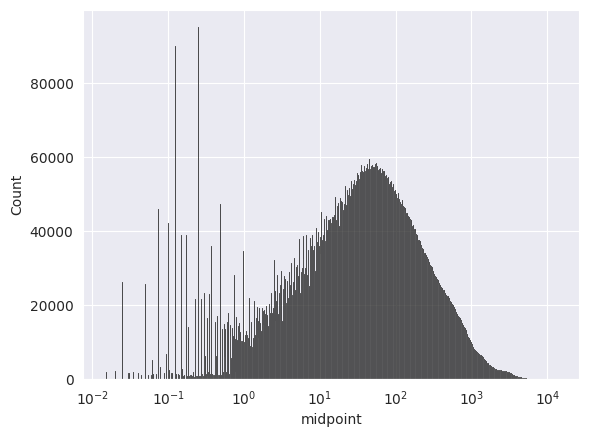

In [ ]:
sns.histplot(results['midpoint'], log_scale=True)

<Axes: xlabel='strike_price', ylabel='Count'>

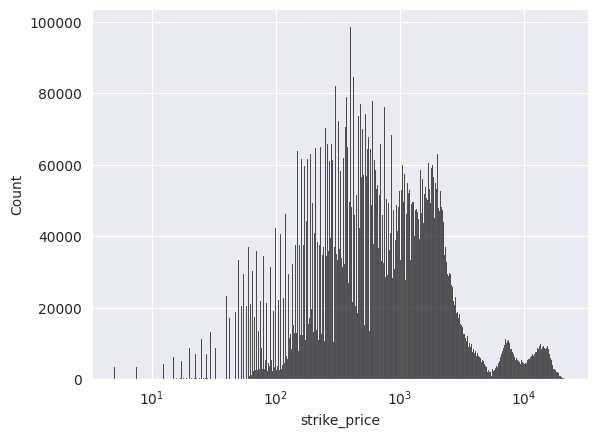

In [ ]:
sns.histplot(results['strike_price'], log_scale=True)

<Axes: xlabel='impl_volatility', ylabel='Count'>

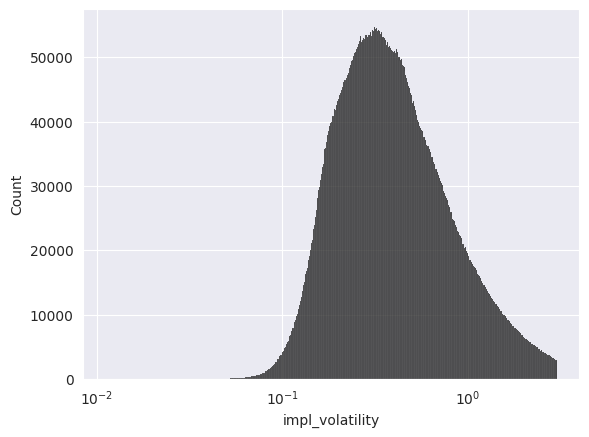

In [ ]:
sns.histplot(results['impl_volatility'], log_scale=True)

<Axes: xlabel='zero_coupon', ylabel='Count'>

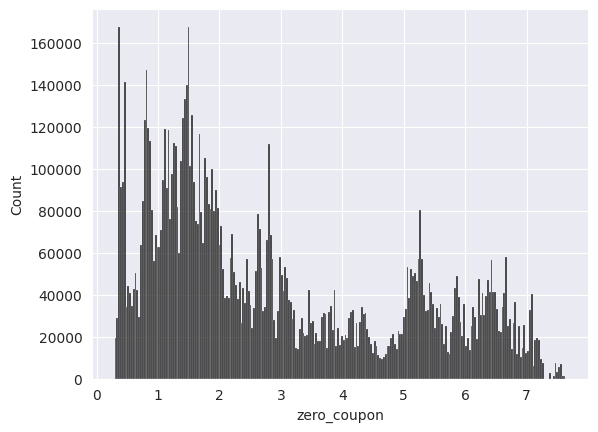

In [ ]:
sns.histplot(results['zero_coupon'])

<Axes: xlabel='div_yield', ylabel='Count'>

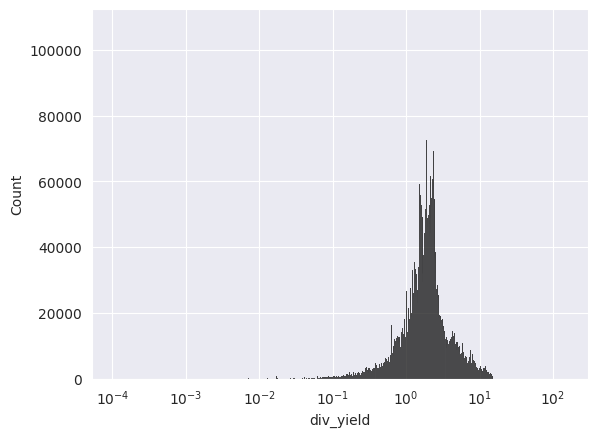

In [ ]:
sns.histplot(results['div_yield'], log_scale=True)

<Axes: xlabel='opt_type', ylabel='count'>

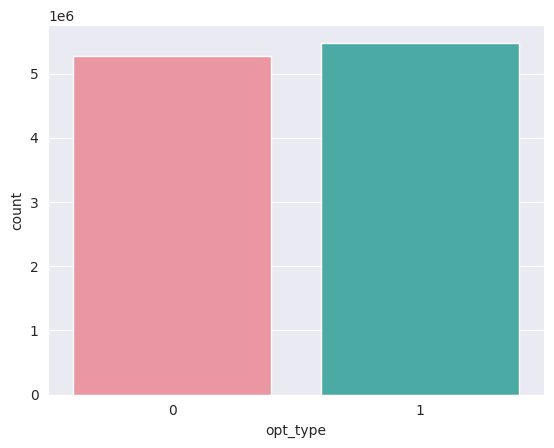

In [ ]:
sns.countplot(x=results['opt_type'])

<Axes: xlabel='time', ylabel='Count'>

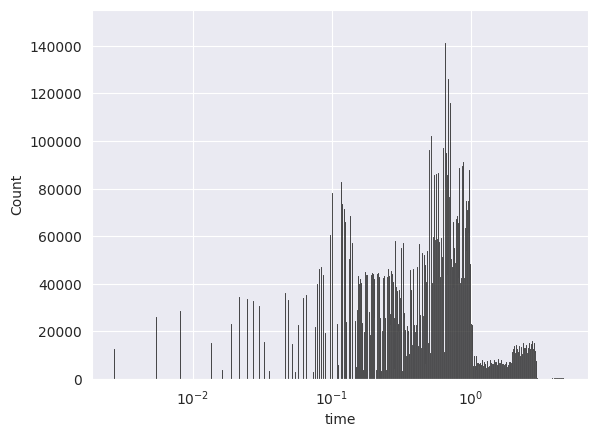

In [ ]:
sns.histplot(results['time'], log_scale=True)

# Data Preparation for Black-Scholes Model

In [ ]:
# Convert Numerical Columns to Float Datatypes
results['strike_price'] = results['strike_price'].astype(float)
results['impl_volatility'] = results['impl_volatility'].astype(float)
results['under_price'] = results['under_price'].astype(float)
results['zero_coupon'] = results['zero_coupon'].astype(float)
results['div_yield'] = results['div_yield'].astype(float)
results['midpoint'] = results['midpoint'].astype(float)
results['opt_type'] = results['opt_type'].astype(float)
results['time'] = results['time'].astype(float)
results['under_lag1'] = results['under_lag1'].astype(float)
results['under_lag2'] = results['under_lag2'].astype(float)
results['under_lag3'] = results['under_lag3'].astype(float)
results['under_lag4'] = results['under_lag4'].astype(float)
results['under_lag5'] = results['under_lag5'].astype(float)
results['under_lag6'] = results['under_lag6'].astype(float)
results['under_lag7'] = results['under_lag7'].astype(float)
results['under_lag8'] = results['under_lag8'].astype(float)
results['under_lag9'] = results['under_lag9'].astype(float)
results['under_lag10'] = results['under_lag10'].astype(float)
results['under_lag11'] = results['under_lag11'].astype(float)
results['under_lag12'] = results['under_lag12'].astype(float)
results['under_lag13'] = results['under_lag13'].astype(float)
results['under_lag14'] = results['under_lag14'].astype(float)
results['under_lag15'] = results['under_lag15'].astype(float)
results['under_lag16'] = results['under_lag16'].astype(float)
results['under_lag17'] = results['under_lag17'].astype(float)
results['under_lag18'] = results['under_lag18'].astype(float)
results['under_lag19'] = results['under_lag19'].astype(float)
results['under_lag20'] = results['under_lag20'].astype(float)

In [ ]:
# Shuffle Rows
data = results.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Drop Columns that will not be used
data = data.drop(['secid', 'date'], axis=1)

In [ ]:
# Calculate indices for the splits
train_idx = int(0.98 * len(data))
val_idx = int(0.99 * len(data))

# Split the data into Training, Validation, and Test Sets
train_data = data.iloc[:train_idx]
val_data = data.iloc[train_idx:val_idx]
test_data = data.iloc[val_idx:]

# Model 1: Black-Scholes Model

In [ ]:
def black_scholes(row):
    # Extract input values from the row
    S = row['under_price']
    K = row['strike_price']
    T = row['time']
    r = row['zero_coupon']/100
    q = row['div_yield']/100
    sigma = row['impl_volatility']/100
    opt_type = row['opt_type']

    # Compute the Black-Scholes option price here
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if opt_type == 1:
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif opt_type == 0:
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return option_price

In [ ]:
bs_results = pd.DataFrame()
# Calculate Black Scholes Values
bs_results['Predicted'] = test_data.apply(black_scholes, axis=1)
# Append True Values to the DataFrames
bs_results['True'] = test_data['midpoint']

# Create a Column of the Difference Between the Predicted and True Values
bs_results['Difference'] = bs_results['Predicted'] - bs_results['True']

# Create a Column for Absolute Error
bs_results['Absolute Error'] = abs(bs_results['Difference'])

# Create a Column for Absolute Percentage Error
bs_results['Absolute Percentage Error'] = abs(bs_results['Difference'] / bs_results['True']) * 100

# Drop the Difference Column
bs_results = bs_results.drop(columns=['Difference'])

# Sort them by True Values Descending
bs_results = bs_results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
bs_results.to_csv('/content/drive/MyDrive/test_results/bs_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
bs_results.head()

,Predicted,True,Absolute Error,Absolute Percentage Error
10655659,5834.198772,5853.55,19.351228,0.330590
10660661,5807.775597,5814.40,6.624403,0.113931
10683099,5798.130276,5807.20,9.069724,0.156181
10676667,5678.557491,5699.50,20.942509,0.367445
10744579,5518.890137,5528.55,9.659863,0.174727


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
bs_results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
10647780,0.0,0.015,0.015,100.0
10733863,0.0,0.015,0.015,100.0
10733861,0.0,0.015,0.015,100.0
10703367,0.0,0.015,0.015,100.0
10700171,0.0,0.015,0.015,100.0


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(bs_results['Absolute Error'].mean(), 2))

Mean Absolute Error: 24.77


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(bs_results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 63.55 %


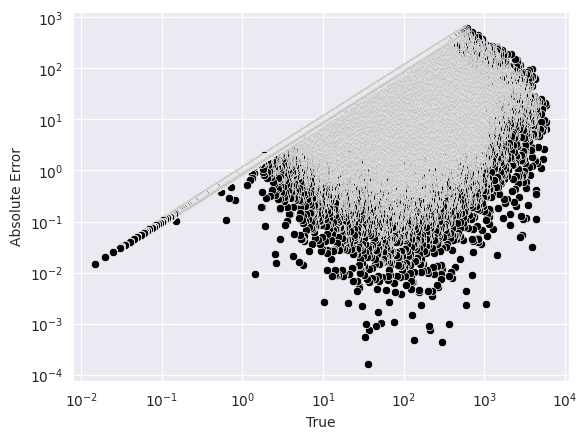

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=bs_results)
plt.xscale('log')
plt.yscale('log')

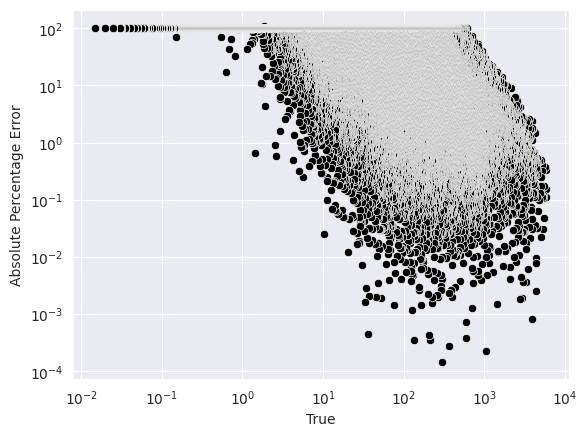

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=bs_results)
plt.xscale('log')
plt.yscale('log')

# Data Preparation for Neural Networks and Gradient Boosters

In [ ]:
# Drop Implied Volatility Column
data = data.drop('impl_volatility', axis=1)

In [ ]:
# Convert data to float16 again in order to decrease memory requirements
data['strike_price'] = data['strike_price'].astype(np.float16)
data['under_price'] = data['under_price'].astype(np.float16)
data['zero_coupon'] = data['zero_coupon'].astype(np.float16)
data['div_yield'] = data['div_yield'].astype(np.float16)
data['midpoint'] = data['midpoint'].astype(np.float16)
data['opt_type'] = data['opt_type'].astype(np.float16)
data['time'] = data['time'].astype(np.float16)
data['under_lag1'] = data['under_lag1'].astype(np.float16)
data['under_lag2'] = data['under_lag2'].astype(np.float16)
data['under_lag3'] = data['under_lag3'].astype(np.float16)
data['under_lag4'] = data['under_lag4'].astype(np.float16)
data['under_lag5'] = data['under_lag5'].astype(np.float16)
data['under_lag6'] = data['under_lag6'].astype(np.float16)
data['under_lag7'] = data['under_lag7'].astype(np.float16)
data['under_lag8'] = data['under_lag8'].astype(np.float16)
data['under_lag9'] = data['under_lag9'].astype(np.float16)
data['under_lag10'] = data['under_lag10'].astype(np.float16)
data['under_lag11'] = data['under_lag11'].astype(np.float16)
data['under_lag12'] = data['under_lag12'].astype(np.float16)
data['under_lag13'] = data['under_lag13'].astype(np.float16)
data['under_lag14'] = data['under_lag14'].astype(np.float16)
data['under_lag15'] = data['under_lag15'].astype(np.float16)
data['under_lag16'] = data['under_lag16'].astype(np.float16)
data['under_lag17'] = data['under_lag17'].astype(np.float16)
data['under_lag18'] = data['under_lag18'].astype(np.float16)
data['under_lag19'] = data['under_lag19'].astype(np.float16)
data['under_lag20'] = data['under_lag20'].astype(np.float16)

In [ ]:
# Save data to Google Drive as a csv file
data.to_csv('/content/drive/MyDrive/data.csv', index=False)

# Switch to TPU Runtime

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost

import gc

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Define a custom color palette with a single black color
black_palette = sns.color_palette(['black'])

# Set the color palette to the custom palette
sns.set_palette(black_palette)

# Set the Style to Darkgrid
sns.set_style("darkgrid")

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check if a TPU is available
if 'COLAB_TPU_ADDR' in os.environ:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print('TPU address is', tpu_address)
else:
    print('No TPU available')

# Set TPU Strategy
tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(tpu_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
tpu_strategy = tf.distribute.TPUStrategy(tpu_resolver)
print("TPU initialized")

# Check the number of TPUs available
devices = tf.config.list_logical_devices('TPU')
print("Number of TPUs available:", len(devices))

TPU address is grpc://10.8.112.130:8470
TPU initialized
Number of TPUs available: 8


In [29]:
# Load the dataset from a CSV file
data = pd.read_csv('/content/drive/MyDrive/data.csv')

In [30]:
# Convert data to float16 in order to decrease memory requirements
data['strike_price'] = data['strike_price'].astype(np.float16)
data['under_price'] = data['under_price'].astype(np.float16)
data['zero_coupon'] = data['zero_coupon'].astype(np.float16)
data['div_yield'] = data['div_yield'].astype(np.float16)
data['midpoint'] = data['midpoint'].astype(np.float16)
data['opt_type'] = data['opt_type'].astype(np.float16)
data['time'] = data['time'].astype(np.float16)
data['under_lag1'] = data['under_lag1'].astype(np.float16)
data['under_lag2'] = data['under_lag2'].astype(np.float16)
data['under_lag3'] = data['under_lag3'].astype(np.float16)
data['under_lag4'] = data['under_lag4'].astype(np.float16)
data['under_lag5'] = data['under_lag5'].astype(np.float16)
data['under_lag6'] = data['under_lag6'].astype(np.float16)
data['under_lag7'] = data['under_lag7'].astype(np.float16)
data['under_lag8'] = data['under_lag8'].astype(np.float16)
data['under_lag9'] = data['under_lag9'].astype(np.float16)
data['under_lag10'] = data['under_lag10'].astype(np.float16)
data['under_lag11'] = data['under_lag11'].astype(np.float16)
data['under_lag12'] = data['under_lag12'].astype(np.float16)
data['under_lag13'] = data['under_lag13'].astype(np.float16)
data['under_lag14'] = data['under_lag14'].astype(np.float16)
data['under_lag15'] = data['under_lag15'].astype(np.float16)
data['under_lag16'] = data['under_lag16'].astype(np.float16)
data['under_lag17'] = data['under_lag17'].astype(np.float16)
data['under_lag18'] = data['under_lag18'].astype(np.float16)
data['under_lag19'] = data['under_lag19'].astype(np.float16)
data['under_lag20'] = data['under_lag20'].astype(np.float16)

# Print the first few rows of the dataframe to verify that the dataset was loaded correctly
data.head()

,strike_price,under_price,zero_coupon,div_yield,midpoint,opt_type,time,under_lag1,under_lag2,under_lag3,...,under_lag11,under_lag12,under_lag13,under_lag14,under_lag15,under_lag16,under_lag17,under_lag18,under_lag19,under_lag20
0,2010.0,1760.000,0.790527,1.740234,289.0000,0.0,0.812988,1729.000,1744.00,1714.000,...,1765.000,1783.000,1794.000,1803.000,1802.000,1803.00,1796.00,1795.000,1798.000,1801.00
1,325.0,376.250,6.656250,1.972656,7.1250,0.0,0.407959,377.500,373.00,369.500,...,389.750,384.750,385.500,379.000,380.500,382.25,380.75,384.500,382.500,384.75
2,115.0,180.625,3.675781,2.087891,66.6875,1.0,0.451660,180.125,182.50,181.875,...,162.625,164.375,159.875,156.125,151.625,149.00,153.25,157.875,160.625,165.75
3,3144.0,4140.000,0.862793,1.597656,996.0000,1.0,0.180664,4128.000,4128.00,4096.000,...,3974.000,3910.000,3890.000,3910.000,3940.000,3914.00,3916.00,3974.000,3962.000,3968.00
4,325.0,285.750,5.195312,1.980469,0.1250,1.0,0.013687,293.000,301.25,306.500,...,307.750,305.750,307.750,301.500,297.500,295.75,298.50,292.750,292.000,287.25


In [31]:
# Separate the 'midpoint' column from the rest of the dataset
X = data.drop('midpoint', axis=1).values
y = data['midpoint'].values

# Free up memory
del data

# Scale the dataset using Min-Max scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into Training, Validation, and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

# Free up memory
del X, y

# Model 2: 3 Layer Feed Forward Neural Network

In [ ]:
# Create the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Define the optimizer with a relatively large learning rate
optimizer = Adam(learning_rate=0.01)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-4)

model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=4096 * tpu_strategy.num_replicas_in_sync, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test data
test_loss, test_mape = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.3f}, Test MAPE: {test_mape:.3f}')

# Save the model
model.save('/content/drive/MyDrive/models/3_Layer_FFNN.h5')

In [ ]:
# Load the best model
best_model = load_model('/content/drive/MyDrive/models/3_Layer_FFNN.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(X_test)

# Create a DataFrame of the Predictions and True Values
test_results = pd.DataFrame({'Predicted': predictions[:, 0], 'True': y_test})

# Create a Column of the Difference Between the Predicted and True Values
test_results['Difference'] = test_results['Predicted'] - test_results['True']

# Create a Column for Absolute Error
test_results['Absolute Error'] = abs(test_results['Difference'])

# Create a Column for Absolute Percentage Error
test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100

# Drop the difference column
test_results = test_results.drop(columns=['Difference'])

# Sort them by True Values Descending
test_results = test_results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
test_results.to_csv('/content/drive/MyDrive/test_results/3_Layer_FFNN.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
test_results.head()

In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
test_results.tail()

In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(test_results['Absolute Error'].mean(), 2))

In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(test_results['Absolute Percentage Error'].mean(), 2), '%')

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

# Model 3: 4 Layer Feed Forward Neural Network

In [ ]:
# Create the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Define the optimizer with a relatively large learning rate
optimizer = Adam(learning_rate=0.01)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-4)

model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=4096 * tpu_strategy.num_replicas_in_sync, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test data
test_loss, test_mape = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.3f}, Test MAPE: {test_mape:.3f}')

# Save the model
model.save('/content/drive/MyDrive/models/4_Layer_FFNN.h5')

In [ ]:
# Load the best model
best_model = load_model('/content/drive/MyDrive/models/4_Layer_FFNN.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(X_test)

# Create a DataFrame of the Predictions and True Values
test_results = pd.DataFrame({'Predicted': predictions[:, 0], 'True': y_test})

# Create a Column of the Difference Between the Predicted and True Values
test_results['Difference'] = test_results['Predicted'] - test_results['True']

# Create a Column for Absolute Error
test_results['Absolute Error'] = abs(test_results['Difference'])

# Create a Column for Absolute Percentage Error
test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100

# Drop the difference column
test_results = test_results.drop(columns=['Difference'])

# Sort them by True Values Descending
test_results = test_results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
test_results.to_csv('/content/drive/MyDrive/test_results/4_Layer_FFNN.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
test_results.head()

In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
test_results.tail()

In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(test_results['Absolute Error'].mean(), 2))

In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(test_results['Absolute Percentage Error'].mean(), 2), '%')

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

# Model 4: 5 Layer Feed Forward Neural Network

In [ ]:
# Create the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Define the optimizer with a relatively large learning rate
optimizer = Adam(learning_rate=0.01)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-4)

model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=4096 * tpu_strategy.num_replicas_in_sync, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test data
test_loss, test_mape = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.3f}, Test MAPE: {test_mape:.3f}')

# Save the model
model.save('/content/drive/MyDrive/models/5_Layer_FFNN.h5')

In [73]:
# Load the best model
best_model = load_model('/content/drive/MyDrive/models/5_Layer_FFNN.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(X_test)

# Create a DataFrame of the Predictions and True Values
test_results = pd.DataFrame({'Predicted': predictions[:, 0], 'True': y_test})

# Create a Column of the Difference Between the Predicted and True Values
test_results['Difference'] = test_results['Predicted'] - test_results['True']

# Create a Column for Absolute Error
test_results['Absolute Error'] = abs(test_results['Difference'])

# Create a Column for Absolute Percentage Error
test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100

# Drop the difference column
test_results = test_results.drop(columns=['Difference'])

# Sort them by True Values Descending
test_results = test_results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
test_results.to_csv('/content/drive/MyDrive/test_results/5_Layer_FFNN.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
test_results.head()

3360/3360 [==============================] - 11s 3ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
19547,5877.153320,5916.0,38.846680,0.656638
8455,5922.006836,5912.0,10.006836,0.169263
95753,5676.999023,5684.0,7.000977,0.123170
55822,5500.781250,5508.0,7.218750,0.131059
27527,5463.049805,5452.0,11.049805,0.202674


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
test_results.tail()

In [75]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(test_results['Absolute Error'].mean(), 2))

Mean Absolute Error: 4.78


In [76]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(test_results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 37.58 %


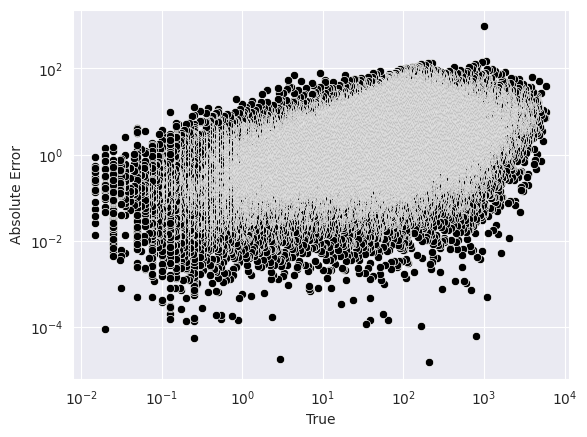

In [77]:
sns.scatterplot(x='True', y='Absolute Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

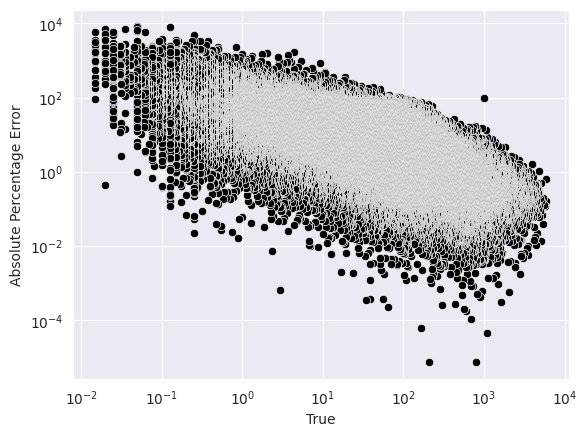

In [78]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

# Switch to GPU Runtime

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import os

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install BetaBoost==0.0.5

In [4]:
# Define a custom color palette with a single black color
black_palette = sns.color_palette(['black'])

# Set the color palette to the custom palette
sns.set_palette(black_palette)

# Set the Style to Darkgrid
sns.set_style("darkgrid")

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Check if a GPU is available
if tf.test.gpu_device_name():
    print('GPU available')
else:
    print('No GPU available')

GPU available


In [17]:
# Load the dataset from a CSV file
data = pd.read_csv('/content/drive/MyDrive/data.csv')

In [18]:
# Convert data to float16 in order to decrease memory requirements
data['strike_price'] = data['strike_price'].astype(np.float16)
data['under_price'] = data['under_price'].astype(np.float16)
data['zero_coupon'] = data['zero_coupon'].astype(np.float16)
data['div_yield'] = data['div_yield'].astype(np.float16)
data['midpoint'] = data['midpoint'].astype(np.float16)
data['opt_type'] = data['opt_type'].astype(np.float16)
data['time'] = data['time'].astype(np.float16)
data['under_lag1'] = data['under_lag1'].astype(np.float16)
data['under_lag2'] = data['under_lag2'].astype(np.float16)
data['under_lag3'] = data['under_lag3'].astype(np.float16)
data['under_lag4'] = data['under_lag4'].astype(np.float16)
data['under_lag5'] = data['under_lag5'].astype(np.float16)
data['under_lag6'] = data['under_lag6'].astype(np.float16)
data['under_lag7'] = data['under_lag7'].astype(np.float16)
data['under_lag8'] = data['under_lag8'].astype(np.float16)
data['under_lag9'] = data['under_lag9'].astype(np.float16)
data['under_lag10'] = data['under_lag10'].astype(np.float16)
data['under_lag11'] = data['under_lag11'].astype(np.float16)
data['under_lag12'] = data['under_lag12'].astype(np.float16)
data['under_lag13'] = data['under_lag13'].astype(np.float16)
data['under_lag14'] = data['under_lag14'].astype(np.float16)
data['under_lag15'] = data['under_lag15'].astype(np.float16)
data['under_lag16'] = data['under_lag16'].astype(np.float16)
data['under_lag17'] = data['under_lag17'].astype(np.float16)
data['under_lag18'] = data['under_lag18'].astype(np.float16)
data['under_lag19'] = data['under_lag19'].astype(np.float16)
data['under_lag20'] = data['under_lag20'].astype(np.float16)

# Print the first few rows of the dataframe to verify that the dataset was loaded correctly
data.head()

,strike_price,under_price,zero_coupon,div_yield,midpoint,opt_type,time,under_lag1,under_lag2,under_lag3,...,under_lag11,under_lag12,under_lag13,under_lag14,under_lag15,under_lag16,under_lag17,under_lag18,under_lag19,under_lag20
0,2010.0,1760.000,0.790527,1.740234,289.0000,0.0,0.812988,1729.000,1744.00,1714.000,...,1765.000,1783.000,1794.000,1803.000,1802.000,1803.00,1796.00,1795.000,1798.000,1801.00
1,325.0,376.250,6.656250,1.972656,7.1250,0.0,0.407959,377.500,373.00,369.500,...,389.750,384.750,385.500,379.000,380.500,382.25,380.75,384.500,382.500,384.75
2,115.0,180.625,3.675781,2.087891,66.6875,1.0,0.451660,180.125,182.50,181.875,...,162.625,164.375,159.875,156.125,151.625,149.00,153.25,157.875,160.625,165.75
3,3144.0,4140.000,0.862793,1.597656,996.0000,1.0,0.180664,4128.000,4128.00,4096.000,...,3974.000,3910.000,3890.000,3910.000,3940.000,3914.00,3916.00,3974.000,3962.000,3968.00
4,325.0,285.750,5.195312,1.980469,0.1250,1.0,0.013687,293.000,301.25,306.500,...,307.750,305.750,307.750,301.500,297.500,295.75,298.50,292.750,292.000,287.25


In [19]:
# Separate the 'midpoint' column from the rest of the dataset
X = data.drop('midpoint', axis=1).values
y = data['midpoint'].values

# Free up memory
del data

# Scale the dataset using Min-Max scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into Training, Validation, and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

# Free up memory
del X, y

# Model 5: XGBoost with Max Depth of 5

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

def eta_decay(iteration):
    max_iter = 10000
    x = iteration + 1
    eta_base = 0.5
    eta_min = 0.2
    eta_decay = eta_min + (eta_base - eta_min) * np.exp(-(x/8)**2 / max_iter)
    return eta_decay

max_iter = 10000
eta_decay = np.array([eta_decay(iteration) for iteration in range(max_iter)])
PARAMS = {
    'booster': 'gbtree',
    'eval_metric': 'mae',  # set eval_metric to 'mae' to use MAE as the evaluation metric
    'max_depth': 5,  # set maximum depth of the trees to 10
    'tree_method': 'gpu_hist'  # set tree_method to 'gpu_hist' to enable GPU acceleration
}

evals_result = {'train': dtrain, 'validation': dval}

progress1 = dict()
result = xgb.train(
    maximize=True,
    params=PARAMS,
    dtrain=dtrain,
    num_boost_round=max_iter,
    early_stopping_rounds=max_iter,
    evals=[(dtrain, 'train'),(dtest, 'test')],
    evals_result=progress1,
    verbose_eval=1,
    callbacks=[xgb.callback.LearningRateScheduler(lambda iteration: eta_decay[iteration])],
)

# Use the trained model for prediction
model = result
y_pred = model.predict(dtest)

# Compute and print the MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Use the model for prediction on the test set
y_pred_test = model.predict(dtest)

# Compute and print the test set MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Test Mean Absolute Error: {mae_test}")

# Save the model
joblib.dump(model, "/content/drive/MyDrive/models/XGBoost_5.joblib")

In [21]:
# Load the best model
best_model = joblib.load('/content/drive/MyDrive/models/XGBoost_5.joblib')

# Create XGBoost DMatrix object for test data
dtest = xgb.DMatrix(X_test)

# Make Predictions on the Test Set
predictions = best_model.predict(dtest)

# Create a DataFrame of the Predictions and True Values
test_results = pd.DataFrame({'Predicted': predictions, 'True': y_test})

# Create a Column of the Difference Between the Predicted and True Values
test_results['Difference'] = test_results['Predicted'] - test_results['True']

# Create a Column for Absolute Error
test_results['Absolute Error'] = abs(test_results['Difference'])

# Create a Column for Absolute Percentage Error
test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100

# Drop the difference column
test_results = test_results.drop(columns=['Difference'])

# Sort them by True Values Descending
test_results = test_results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
test_results.to_csv('/content/drive/MyDrive/test_results/XGBoost_5.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
test_results.head()

,Predicted,True,Absolute Error,Absolute Percentage Error
19547,5979.518066,5916.0,63.518066,1.073666
8455,5926.788574,5912.0,14.788574,0.250145
95753,5440.022461,5684.0,243.977539,4.292356
55822,5562.759277,5508.0,54.759277,0.994177
27527,5572.155762,5452.0,120.155762,2.203884


In [22]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
test_results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
4387,-2.932978,0.014999,2.947978,19653.986328
1650,1.272250,0.014999,1.257250,8382.008789
31370,-0.418705,0.014999,0.433704,2891.479980
18061,0.689618,0.014999,0.674619,4497.641602
33720,-1.779155,0.014999,1.794154,11961.515625


In [23]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(test_results['Absolute Error'].mean(), 2))

Mean Absolute Error: 10.44


In [24]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(test_results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 228.16 %


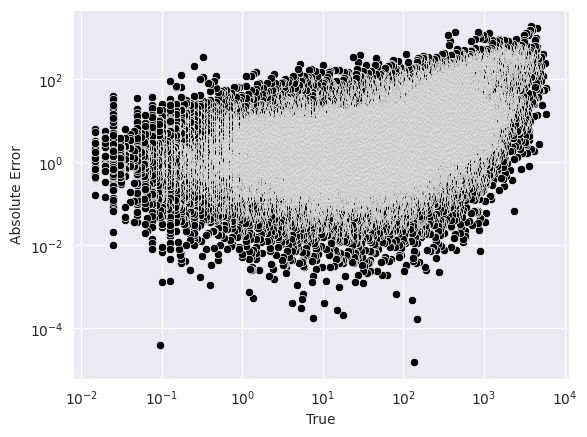

In [25]:
sns.scatterplot(x='True', y='Absolute Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

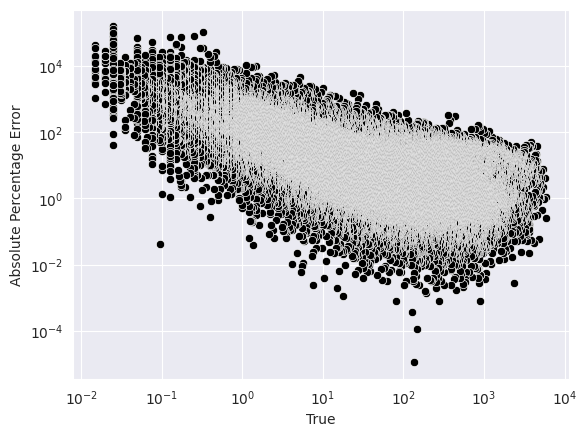

In [26]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

# Model 5: XGBoost with Max Depth of 10

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

def eta_decay(iteration):
    max_iter = 10000
    x = iteration + 1
    eta_base = 0.5
    eta_min = 0.2
    eta_decay = eta_min + (eta_base - eta_min) * np.exp(-(x/8)**2 / max_iter)
    return eta_decay

max_iter = 10000
eta_decay = np.array([eta_decay(iteration) for iteration in range(max_iter)])
PARAMS = {
    'booster': 'gbtree',
    'eval_metric': 'mae',  # set eval_metric to 'mae' to use MAE as the evaluation metric
    'max_depth': 10,  # set maximum depth of the trees to 10
    'tree_method': 'gpu_hist'  # set tree_method to 'gpu_hist' to enable GPU acceleration
}

evals_result = {'train': dtrain, 'validation': dval}

progress1 = dict()
result = xgb.train(
    maximize=True,
    params=PARAMS,
    dtrain=dtrain,
    num_boost_round=max_iter,
    early_stopping_rounds=max_iter,
    evals=[(dtrain, 'train'),(dtest, 'test')],
    evals_result=progress1,
    verbose_eval=1,
    callbacks=[xgb.callback.LearningRateScheduler(lambda iteration: eta_decay[iteration])],
)

# Use the trained model for prediction
model = result
y_pred = model.predict(dtest)

# Compute and print the MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Use the model for prediction on the test set
y_pred_test = model.predict(dtest)

# Compute and print the test set MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Test Mean Absolute Error: {mae_test}")

# Save the model
joblib.dump(model, "/content/drive/MyDrive/models/XGBoost_10.joblib")

In [28]:
# Load the best model
best_model = joblib.load('/content/drive/MyDrive/models/XGBoost_10.joblib')

# Create XGBoost DMatrix object for test data
dtest = xgb.DMatrix(X_test)

# Make Predictions on the Test Set
predictions = best_model.predict(dtest)

# Create a DataFrame of the Predictions and True Values
test_results = pd.DataFrame({'Predicted': predictions, 'True': y_test})

# Create a Column of the Difference Between the Predicted and True Values
test_results['Difference'] = test_results['Predicted'] - test_results['True']

# Create a Column for Absolute Error
test_results['Absolute Error'] = abs(test_results['Difference'])

# Create a Column for Absolute Percentage Error
test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100

# Drop the difference column
test_results = test_results.drop(columns=['Difference'])

# Sort them by True Values Descending
test_results = test_results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
test_results.to_csv('/content/drive/MyDrive/test_results/XGBoost_10.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
test_results.head()

,Predicted,True,Absolute Error,Absolute Percentage Error
19547,6016.601074,5916.0,100.601074,1.700491
8455,5938.200195,5912.0,26.200195,0.443170
95753,5450.525879,5684.0,233.474121,4.107567
55822,5652.881348,5508.0,144.881348,2.630380
27527,5568.863281,5452.0,116.863281,2.143494


In [29]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
test_results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
4387,1.516094,0.014999,1.501095,10007.705078
1650,0.771505,0.014999,0.756506,5043.576660
31370,0.095375,0.014999,0.080376,535.862061
18061,-0.059973,0.014999,0.074972,499.833771
33720,0.426121,0.014999,0.411121,2740.919678


In [30]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(test_results['Absolute Error'].mean(), 2))

Mean Absolute Error: 7.4


In [31]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(test_results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 53.22 %


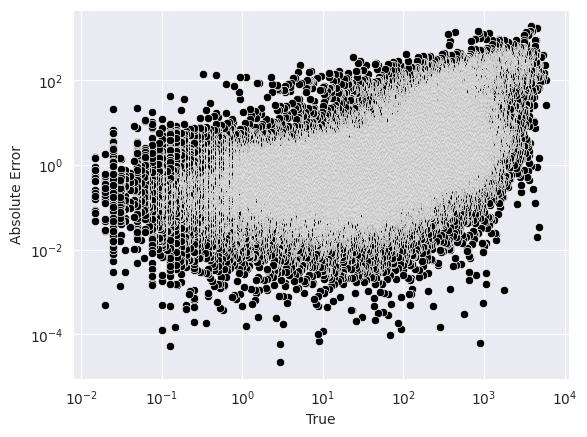

In [32]:
sns.scatterplot(x='True', y='Absolute Error', data=test_results)
plt.xscale('log')
plt.yscale('log')

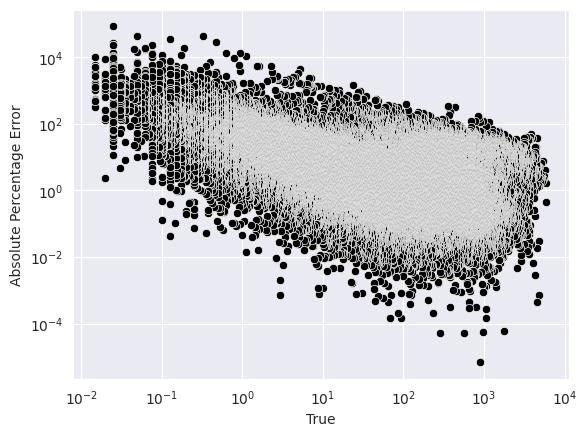

In [33]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=test_results)
plt.xscale('log')
plt.yscale('log')